In [1]:
!pip install brminer

In [2]:
!pip install autorank

In [3]:
import numpy as np
import math
import os
import random
import pandas as pd
import csv
import matplotlib.pyplot as plt

#### Models ####
import brminer
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM

#### For the new BRM implementations ####
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

#### For database preprocessing ####
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#### Statistical tests ####
from autorank import autorank, plot_stats, create_report, latex_table

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### BRM with different dissimilarity metrics

*   Manhattan Distance (manhattanBRM)
*   Cosine Distance  (cosineBRM)
*   Chebyshev Distance (chebyshevBRM)

In [ ]:
class manhattanBRM(brminer.BRM):
    def __init__(self, classifier_count=100, bootstrap_sample_percent=100, use_bootstrap_sample_count=False, bootstrap_sample_count=0, use_past_even_queue=False, max_event_count=3, alpha=0.5, user_threshold=95):
        self.classifier_count = classifier_count
        self.bootstrap_sample_percent = bootstrap_sample_percent
        self.use_bootstrap_sample_count = use_bootstrap_sample_count
        self.bootstrap_sample_count = bootstrap_sample_count
        self.use_past_even_queue = use_past_even_queue
        self.max_event_count = max_event_count
        self.alpha = alpha
        self.user_threshold = user_threshold
        

    def score_samples(self, X):
        X = np.array(X)
        X_test = self._scaler.transform(X)

        result = []
        batch_size = 100
        for i in range(min(len(X_test), batch_size), len(X_test) + batch_size, batch_size):
            current_X_test = X_test[[j for j in range(max(0, i-batch_size), min(i, len(X_test)))]]

            current_similarity = np.average([np.exp(-np.power(np.amin(manhattan_distances(current_X_test, self._centers[i]), axis=1)/self._max_dissimilarity, 2)/(self._sd[i])) for i in range(len(self._centers))], axis=0)
        
            result = result + [j for j in list(map(self._evaluate, current_similarity))]

        return result

    def fit(self, X, y = None):
        # Check that X and y have correct shape
        if y is not None:
            X_train, y_train = check_X_y(X, y)
        else:
             X_train = check_array(X)
             
        self._similarity_sum = 0
        self._is_threshold_Computed = False

        self.n_features_in_ = X_train.shape[1]

        if self.n_features_in_ < 1:
            raise ValueError('Unable to instantiate the train dataset - Empty vector')     
        
        self._scaler = MinMaxScaler()
        X_train = pd.DataFrame(X_train)
        X_train = pd.DataFrame(self._scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)


        self._max_dissimilarity = math.sqrt(self.n_features_in_)
        self._sd = np.empty(0)
        sampleSize = int(self.bootstrap_sample_count) if (self.use_bootstrap_sample_count) else int(0.01 * self.bootstrap_sample_percent * len(X_train));
        self._centers = np.empty((0, sampleSize, self.n_features_in_))

        list_instances = X_train.values.tolist()
        for i in range(0, self.classifier_count):            
            centers = random.choices(list_instances, k=sampleSize)
            self._centers = np.insert(self._centers, i, centers, axis=0)
            self._sd = np.insert(self._sd, i, 2*(np.mean(manhattan_distances(centers, centers))/self._max_dissimilarity)**2)

        return self

In [ ]:
class cosineBRM(brminer.BRM):
    def __init__(self, classifier_count=100, bootstrap_sample_percent=100, use_bootstrap_sample_count=False, bootstrap_sample_count=0, use_past_even_queue=False, max_event_count=3, alpha=0.5, user_threshold=95):
        self.classifier_count = classifier_count
        self.bootstrap_sample_percent = bootstrap_sample_percent
        self.use_bootstrap_sample_count = use_bootstrap_sample_count
        self.bootstrap_sample_count = bootstrap_sample_count
        self.use_past_even_queue = use_past_even_queue
        self.max_event_count = max_event_count
        self.alpha = alpha
        self.user_threshold = user_threshold
        

    def score_samples(self, X):
        X = np.array(X)
        X_test = self._scaler.transform(X)

        result = []
        batch_size = 100
        for i in range(min(len(X_test), batch_size), len(X_test) + batch_size, batch_size):
            current_X_test = X_test[[j for j in range(max(0, i-batch_size), min(i, len(X_test)))]]

            current_similarity = np.average([np.exp(-np.power(np.amin(cosine_distances(current_X_test, self._centers[i]), axis=1)/self._max_dissimilarity, 2)/(self._sd[i])) for i in range(len(self._centers))], axis=0)
        
            result = result + [j for j in list(map(self._evaluate, current_similarity))]

        return result

    def fit(self, X, y = None):
        # Check that X and y have correct shape
        if y is not None:
            X_train, y_train = check_X_y(X, y)
        else:
             X_train = check_array(X)
             
        self._similarity_sum = 0
        self._is_threshold_Computed = False

        self.n_features_in_ = X_train.shape[1]

        if self.n_features_in_ < 1:
            raise ValueError('Unable to instantiate the train dataset - Empty vector')     
        
        self._scaler = MinMaxScaler()
        X_train = pd.DataFrame(X_train)
        X_train = pd.DataFrame(self._scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)


        self._max_dissimilarity = math.sqrt(self.n_features_in_)
        self._sd = np.empty(0)
        sampleSize = int(self.bootstrap_sample_count) if (self.use_bootstrap_sample_count) else int(0.01 * self.bootstrap_sample_percent * len(X_train));
        self._centers = np.empty((0, sampleSize, self.n_features_in_))

        list_instances = X_train.values.tolist()
        for i in range(0, self.classifier_count):            
            centers = random.choices(list_instances, k=sampleSize)
            self._centers = np.insert(self._centers, i, centers, axis=0)
            self._sd = np.insert(self._sd, i, 2*(np.mean(cosine_distances(centers, centers))/self._max_dissimilarity)**2)

        return self

In [ ]:
class chebyshevBRM(brminer.BRM):
    def __init__(self, classifier_count=100, bootstrap_sample_percent=100, use_bootstrap_sample_count=False, bootstrap_sample_count=0, use_past_even_queue=False, max_event_count=3, alpha=0.5, user_threshold=95):
        self.classifier_count = classifier_count
        self.bootstrap_sample_percent = bootstrap_sample_percent
        self.use_bootstrap_sample_count = use_bootstrap_sample_count
        self.bootstrap_sample_count = bootstrap_sample_count
        self.use_past_even_queue = use_past_even_queue
        self.max_event_count = max_event_count
        self.alpha = alpha
        self.user_threshold = user_threshold
        

    def score_samples(self, X):
        X = np.array(X)
        X_test = self._scaler.transform(X)

        result = []
        batch_size = 100
        for i in range(min(len(X_test), batch_size), len(X_test) + batch_size, batch_size):
            current_X_test = X_test[[j for j in range(max(0, i-batch_size), min(i, len(X_test)))]]

            current_similarity = np.average([np.exp(-np.power(np.amin(pairwise_distances(current_X_test, self._centers[i], metric='chebyshev'), axis=1)/self._max_dissimilarity, 2)/(self._sd[i])) for i in range(len(self._centers))], axis=0)
        
            result = result + [j for j in list(map(self._evaluate, current_similarity))]

        return result

    def fit(self, X, y = None):
        # Check that X and y have correct shape
        if y is not None:
            X_train, y_train = check_X_y(X, y)
        else:
             X_train = check_array(X)
             
        self._similarity_sum = 0
        self._is_threshold_Computed = False

        self.n_features_in_ = X_train.shape[1]

        if self.n_features_in_ < 1:
            raise ValueError('Unable to instantiate the train dataset - Empty vector')     
        
        self._scaler = MinMaxScaler()
        X_train = pd.DataFrame(X_train)
        X_train = pd.DataFrame(self._scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)


        self._max_dissimilarity = math.sqrt(self.n_features_in_)
        self._sd = np.empty(0)
        sampleSize = int(self.bootstrap_sample_count) if (self.use_bootstrap_sample_count) else int(0.01 * self.bootstrap_sample_percent * len(X_train));
        self._centers = np.empty((0, sampleSize, self.n_features_in_))

        list_instances = X_train.values.tolist()
        for i in range(0, self.classifier_count):            
            centers = random.choices(list_instances, k=sampleSize)
            self._centers = np.insert(self._centers, i, centers, axis=0)
            self._sd = np.insert(self._sd, i, 2*(np.mean(pairwise_distances(centers, centers, metric='chebyshev'))/self._max_dissimilarity)**2)

        return self

#### Data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def importdata(trainFile, testFile): 
    train = pd.read_csv(trainFile, sep= ',') 
    test = pd.read_csv(testFile, sep= ',') 
    return train, test

def cleantrain(trainFile):
  headertrain = []
  with open(trainFile, 'r') as inp:
    linestrain = inp.readlines()
    for line in linestrain:
      if '@inputs' in line:
        headertrain = line.replace("@inputs ", '').replace("\n",'').split(',')
        headertrain.append('Class')
      if '@input' in line:
        headertrain = line.replace("@input ", '').replace("\n",'').split(',')
        headertrain.append('Class')      
  with open(trainFile, 'w') as out:
    train = csv.DictWriter(out, fieldnames=headertrain)
    train.writeheader()
    for line in linestrain:
      if not '@' in line:
            out.write(line)
    return

def cleantest(testFile):
  headertest = []
  with open(testFile, 'r') as inp:
    linestest = inp.readlines()
    for line in linestest:
      if '@inputs' in line:
        headertest = line.replace("@inputs ", '').replace("\n",'').split(',')
        headertest.append('Class')
      if '@input' in line:
        headertest = line.replace("@input ", '').replace("\n",'').split(',')
        headertest.append('Class')
  with open(testFile, 'w') as out:
    test = csv.DictWriter(out, fieldnames=headertest)
    test.writeheader()
    for line in linestest:
      if not '@' in line:
            out.write(line)
    return

def splitdataset(train, test): 
    ohe = OneHotEncoder(sparse=True)
    objInTrain = len(train)

    allData = pd.concat([train, test], ignore_index=True, sort =False, axis=0)
    AllDataWihoutClass = allData.iloc[:, :-1]
    AllDataWihoutClassOnlyNominals = AllDataWihoutClass.select_dtypes(include=['object'])
    AllDataWihoutClassNoNominals = AllDataWihoutClass.select_dtypes(exclude=['object'])

    encAllDataWihoutClassNominals = ohe.fit_transform(AllDataWihoutClassOnlyNominals)
    encAllDataWihoutClassNominalsToPanda = pd.DataFrame(encAllDataWihoutClassNominals.toarray())
    
    if AllDataWihoutClassOnlyNominals.shape[1] > 0:
      codAllDataAgain = pd.concat([encAllDataWihoutClassNominalsToPanda, AllDataWihoutClassNoNominals], ignore_index=True, sort =False, axis=1)
    else:
      codAllDataAgain = AllDataWihoutClass

    # Seperating the target variable 
    X_train = codAllDataAgain[:objInTrain]
    y_train = train.values[:, -1]

    X_test = codAllDataAgain[objInTrain:]
    y_test = test.values[:, -1]
    return X_train, X_test, y_train, y_test

#### Modeling

In [ ]:
def plot_auc(df_model, title):
    """
        Creates a box plot for the models according to an aggregate function
        for AUC
    """
    df_model.boxplot(by='model', meanline=True, showmeans=True, showcaps=True, 
           showbox=True, showfliers=False, figsize=(15,15))
    plt.title(title)
    plt.show()
    
def test_model(name, test, Y):
    """
        Calculates AUC for the model
    """
    db_name = name[0]
    clf = name[1]
    auc = metrics.roc_auc_score(test,  Y)
    d = {'db': [db_name], 'model': [clf], 'auc': [auc]}
    df_auc = pd.DataFrame(data=d)
    return df_auc

def train_BRM(db_name, train, test):
    """
        Trains and test the Bagging-Random Miner (BRM)
    """
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    model = brminer.BRM()
    model.fit(train_x, train_y) 
    Y = model.score_samples(test_x)
    df_auc = test_model((db_name,'BRM'),test_y, Y)
    return df_auc

def train_manhattanBRM(db_name, train, test):
    """
        Trains and test the Bagging-Random Miner (BRM)
    """
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    model = manhattanBRM()
    model.fit(train_x, train_y) 
    Y = model.score_samples(test_x)
    df_auc = test_model((db_name,'manhattanBRM'),test_y, Y)
    return df_auc

def train_cosineBRM(db_name, train, test):
    """
        Trains and test the Bagging-Random Miner (BRM)
    """
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    model = cosineBRM()
    model.fit(train_x, train_y) 
    Y = model.score_samples(test_x)
    df_auc = test_model((db_name,'cosineBRM'),test_y, Y)
    return df_auc

def train_chebyshevBRM(db_name, train, test):
    """
        Trains and test the Bagging-Random Miner (BRM)
    """
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    model = chebyshevBRM()
    model.fit(train_x, train_y) 
    Y = model.score_samples(test_x)
    df_auc = test_model((db_name,'chebyshevBRM'),test_y, Y)
    return df_auc

def train_GMM(db_name, train, test):
    """
        Trains and test the Gaussian Mixture Model (GMM)
    """
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    n_classes = len(set(train_y))
    model = GaussianMixture(n_components=n_classes, random_state=0)
    model.fit(train_x)
    Y = model.predict(test_x)
    df_auc = test_model((db_name,'GMM'), test_y, Y)
    return df_auc

def train_ISOF(db_name, train, test):
    """
        Trains and test the Isolation Forest (ISOF)
    """
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    model = IsolationForest(random_state=0).fit(train_x)
    Y = model.predict(test_x)
    df_auc = test_model((db_name, 'ISOF'),test_y, Y)
    return df_auc

def train_OCSVM(db_name, train, test):
    """
        Trains and test the One-Class Support Vector Machines (ocSVM)
    """
    train_x = train[0]
    train_y = train[1]
    test_x = test[0]
    test_y = test[1]
    model = OneClassSVM().fit(train_x)
    Y = model.predict(test_x)
    df_auc = test_model((db_name, 'OCSVM'),test_y, Y)
    return df_auc

def test_classifier(name, train, test):
    """
        Returns the AUC evaluation given a classifier name
        Train is a tuple (train_x, train_y)
        Test is a tuple (test_x, test_y)
    """
    db = name[0]
    model = name[1]
    if model == 'BRM':
        df_auc = train_BRM(db, train, test)
    elif model == 'GMM':
        df_auc = train_GMM(db, train, test)
    elif model == 'ISOF':
        df_auc = train_ISOF(db, train, test)
    elif model == 'OCSVM':
        df_auc = train_OCSVM(db, train, test)
    elif model == 'manhattanBRM':
        df_auc = train_manhattanBRM(db, train, test)
    elif model == 'cosineBRM':
        df_auc = train_cosineBRM(db, train, test)
    elif model == 'chebyshevBRM':
        df_auc = train_chebyshevBRM(db, train, test)
    return df_auc

In [ ]:
def plot_models(results=['minmax.csv','normal.csv','std.csv']):
    """
        Plot the results of the models given some aggregates
    """
    for r in results:
        df_m = pd.read_csv(r)
        title = r.split('.')
        plot_auc(df_m, title[0])

In [ ]:
# Function importing Dataset 
def get_data():
  rootDir = '/content/drive/MyDrive/Colab Notebooks/Unsupervised_Anomaly_Detection'

  normal_models = pd.DataFrame()
  std_models = pd.DataFrame()
  minmax_models = pd.DataFrame()

  data = {'folder_name': []}
  for dirName, subdirList, fileList in os.walk(rootDir):
      print('Directorio encontrado: %s' % dirName)
      print("************************************ DIRECTORIO **************************************")
      if len(fileList) > 0:
        arr_folder_name = dirName.split("/")
        folder_name = arr_folder_name[len(arr_folder_name) - 1]
        completed_name = folder_name + "-5-"
        print(completed_name)
        db_name = folder_name

        for i in range(1, int(len(fileList) / 2) + 1):
          print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            # Finding data
#          print(str(dirName) + '/'+ completed_name + str(i) +"tra.dat")
#          print(str(dirName) + '/' + completed_name + str(i) +"tst.dat")
          if os.path.exists(str(dirName) + '/'+ completed_name + str(i) +"tra.dat"):
            os.rename(str(dirName) + '/' + completed_name + str(i) +"tra.dat", str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv")
          if os.path.exists(str(dirName) + '/' + completed_name + str(i) +"tst.dat"):
            os.rename(str(dirName) + '/' + completed_name + str(i) +"tst.dat", str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv")
          trainFile = str(dirName) + '/' + completed_name + str(i) +"tra.dat.csv"
          testFile = str(dirName) + '/' + completed_name + str(i) +"tst.dat.csv"
          print('trainFile ' + trainFile)
          print('testFile ' + testFile)
             # Cleaning data and getting header
          cleantrain(trainFile)
          cleantest(testFile)

          #Classifier names
          model = ['BRM','GMM','ISOF','OCSVM','manhattanBRM','cosineBRM','chebyshevBRM']
          # Loading data          
          train, test = importdata(trainFile, testFile)

          #Split the dataset
          X_train, X_test, y_train, y_test = splitdataset(train, test)

          for m in model:
            normal_models = normal_models.append(test_classifier((db_name, m), train=[X_train,y_train], test=[X_test,y_test]))

          #Standard scaling
          X_train_std, X_test_std = scale_data(X_train, X_test, y_train, y_test)
          
          for m in model:
            std_models = std_models.append(test_classifier((db_name, m), train=[X_train,y_train], test=[X_test,y_test]))

          #Minmax scaling
          X_train_minmax, X_test_minmax = minmax_data(X_train, X_test, y_train, y_test)

          for m in model:
            minmax_models = minmax_models.append(test_classifier((db_name, m), train=[X_train,y_train], test=[X_test,y_test]))

  return [normal_models,std_models,minmax_models]

def scale_data(X_train, X_test, y_train, y_test):
    std_scaler = StandardScaler()
    X_train_std = pd.DataFrame(std_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_std = pd.DataFrame(std_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    return X_train_std, X_test_std

def minmax_data(X_train, X_test, y_train, y_test):
    mm_scaler = MinMaxScaler()
    X_train_minmax = pd.DataFrame(mm_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_minmax = pd.DataFrame(mm_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    return X_train_minmax, X_test_minmax

In [ ]:
results = get_data()

Directorio encontrado: /content/drive/MyDrive/Colab Notebooks/Unsupervised_Anomaly_Detection
************************************ DIRECTORIO **************************************
Directorio encontrado: /content/drive/MyDrive/Colab Notebooks/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen
************************************ DIRECTORIO **************************************
kr-vs-k-zero_vs_fifteen-5-
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
trainFile /content/drive/MyDrive/Colab Notebooks/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tra.dat.csv
testFile /content/drive/MyDrive/Colab Notebooks/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_fifteen/kr-vs-k-zero_vs_fifteen-5-1tst.dat.csv
Directorio encontrado: /content/drive/MyDrive/Colab Notebooks/Unsupervised_Anomaly_Detection/kr-vs-k-zero_vs_eight
************************************ DIRECTORIO **************************************
kr-vs-k-zero_vs_e

In [ ]:
results[0].to_csv('normal.csv',index=False)

In [ ]:
results[0].head(7)

,db,model,auc
0,kr-vs-k-zero_vs_fifteen,BRM,0.264049
0,kr-vs-k-zero_vs_fifteen,GMM,0.758276
0,kr-vs-k-zero_vs_fifteen,ISOF,0.068129
0,kr-vs-k-zero_vs_fifteen,OCSVM,0.240185
0,kr-vs-k-zero_vs_fifteen,manhattanBRM,0.309854
0,kr-vs-k-zero_vs_fifteen,cosineBRM,0.214396
0,kr-vs-k-zero_vs_fifteen,chebyshevBRM,0.278676


In [ ]:
results[1].to_csv('std.csv',index=False)

In [ ]:
results[1].head(7)

,db,model,auc
0,kr-vs-k-zero_vs_fifteen,BRM,0.255581
0,kr-vs-k-zero_vs_fifteen,GMM,0.758276
0,kr-vs-k-zero_vs_fifteen,ISOF,0.068129
0,kr-vs-k-zero_vs_fifteen,OCSVM,0.240185
0,kr-vs-k-zero_vs_fifteen,manhattanBRM,0.264434
0,kr-vs-k-zero_vs_fifteen,cosineBRM,0.267898
0,kr-vs-k-zero_vs_fifteen,chebyshevBRM,0.237875


In [ ]:
results[2].to_csv('minmax.csv',index=False)

In [ ]:
results[2].head(7)

,db,model,auc
0,kr-vs-k-zero_vs_fifteen,BRM,0.277521
0,kr-vs-k-zero_vs_fifteen,GMM,0.758276
0,kr-vs-k-zero_vs_fifteen,ISOF,0.068129
0,kr-vs-k-zero_vs_fifteen,OCSVM,0.240185
0,kr-vs-k-zero_vs_fifteen,manhattanBRM,0.275212
0,kr-vs-k-zero_vs_fifteen,cosineBRM,0.280600
0,kr-vs-k-zero_vs_fifteen,chebyshevBRM,0.254042


## Visualization

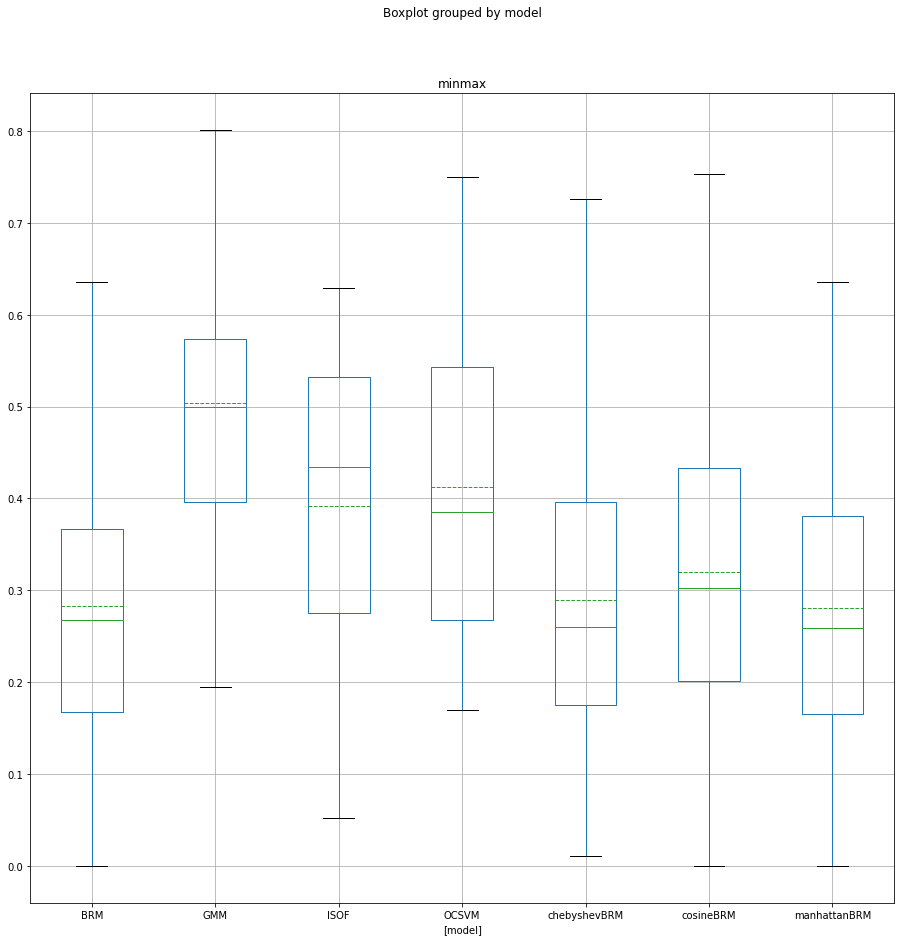

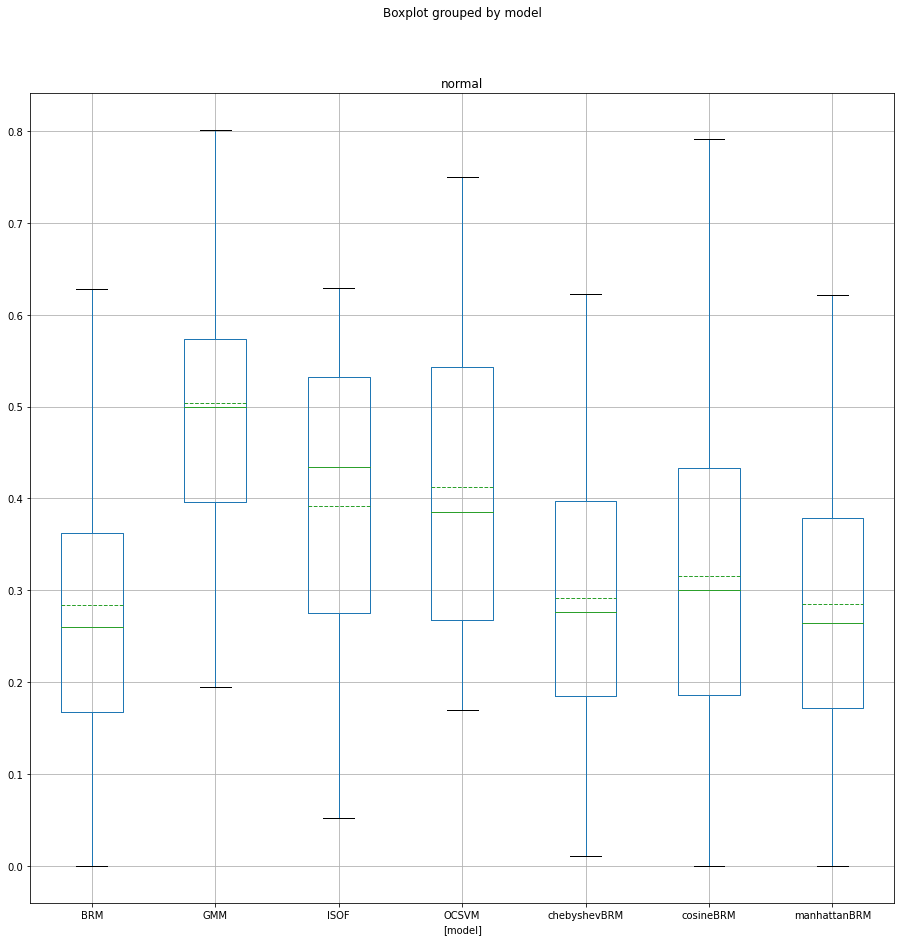

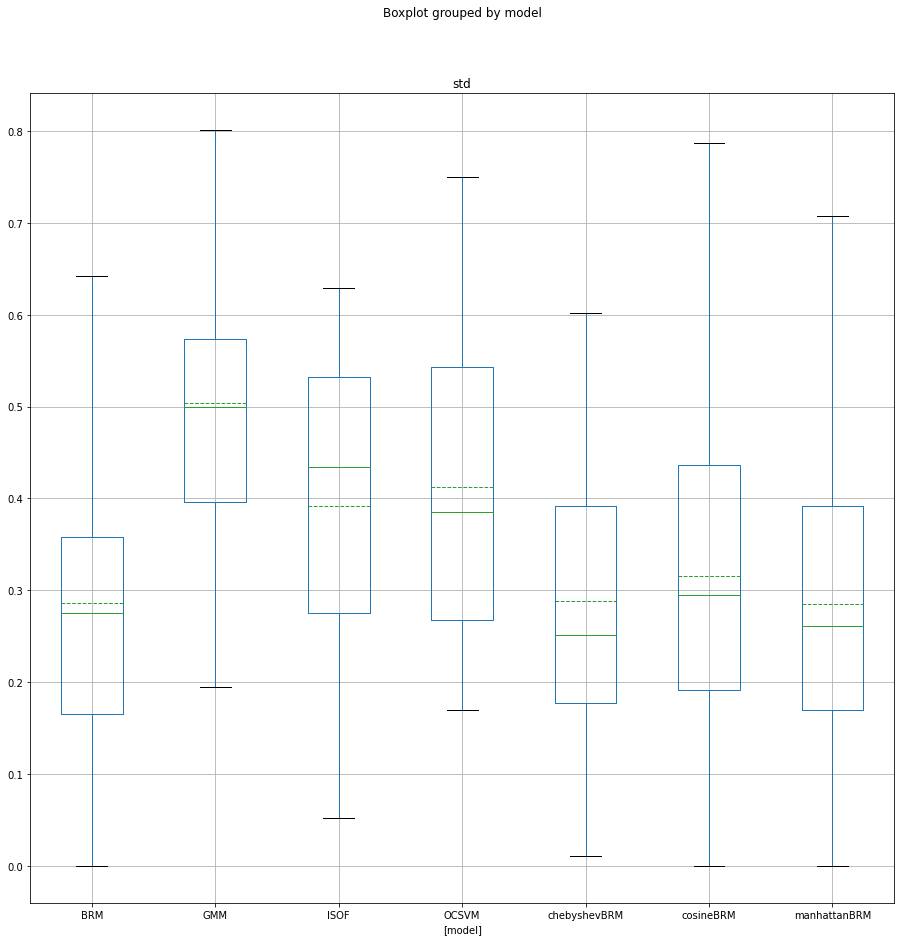

In [ ]:
plot_models()

## Statistical Tests

Tool used:
* https://www.theoj.org/joss-papers/joss.02173/10.21105.joss.02173.pdf

In [ ]:
normal_df = pd.read_csv('normal.csv', index_col='db')
normal = normal_df.pivot_table('auc', 'db', 'model')
stat_res = autorank(normal)

In [ ]:
create_report(stat_res)

The statistical analysis was conducted for 7 populations with 60 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations ISOF (p=0.004) and cosineBRM (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.163 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that the

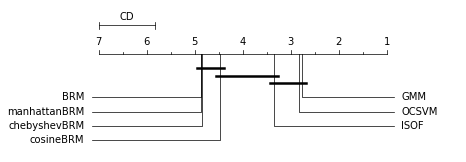

In [ ]:
plot_stats(stat_res)
plt.show()

In [ ]:
latex_table(stat_res)

\begin{table}[h]
\centering
\begin{tabular}{lrrllll}
\toprule
{} &    MR &   MED &   MAD &              CI & $\gamma$ &   Magnitude \\
model        &       &       &       &                 &           &             \\
\midrule
GMM          & 2.758 & 0.500 & 0.134 &  [0.399, 0.589] &     0.000 &  negligible \\
OCSVM        & 2.833 & 0.385 & 0.202 &  [0.270, 0.553] &     0.671 &      medium \\
ISOF         & 3.350 & 0.435 & 0.194 &  [0.284, 0.550] &     0.392 &       small \\
cosineBRM    & 4.475 & 0.300 & 0.195 &  [0.192, 0.444] &     1.195 &       large \\
chebyshevBRM & 4.842 & 0.277 & 0.155 &  [0.187, 0.410] &     1.543 &       large \\
manhattanBRM & 4.867 & 0.264 & 0.156 &  [0.173, 0.411] &     1.620 &       large \\
BRM          & 4.875 & 0.260 & 0.140 &  [0.169, 0.385] &     1.745 &       large \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}


In [ ]:
std_df = pd.read_csv('std.csv', index_col='db')
std = std_df.pivot_table('auc', 'db', 'model')
stat_res = autorank(std)

In [ ]:
create_report(stat_res)

The statistical analysis was conducted for 7 populations with 60 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations ISOF (p=0.004) and cosineBRM (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.163 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that the

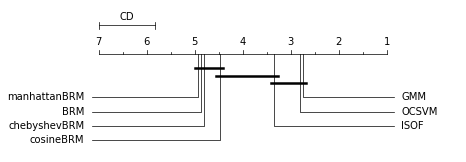

In [ ]:
plot_stats(stat_res)
plt.show()

In [ ]:
latex_table(stat_res)

\begin{table}[h]
\centering
\begin{tabular}{lrrllll}
\toprule
{} &    MR &   MED &   MAD &              CI & $\gamma$ &   Magnitude \\
model        &       &       &       &                 &           &             \\
\midrule
GMM          & 2.750 & 0.500 & 0.134 &  [0.399, 0.589] &     0.000 &  negligible \\
OCSVM        & 2.817 & 0.385 & 0.202 &  [0.270, 0.553] &     0.671 &      medium \\
ISOF         & 3.342 & 0.435 & 0.194 &  [0.284, 0.550] &     0.392 &       small \\
cosineBRM    & 4.483 & 0.295 & 0.182 &  [0.193, 0.449] &     1.282 &       large \\
chebyshevBRM & 4.817 & 0.251 & 0.130 &  [0.180, 0.410] &     1.883 &       large \\
BRM          & 4.867 & 0.275 & 0.162 &  [0.165, 0.403] &     1.512 &       large \\
manhattanBRM & 4.925 & 0.261 & 0.167 &  [0.173, 0.408] &     1.581 &       large \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}


In [ ]:
minmax_df = pd.read_csv('minmax.csv', index_col='db')
minmax = minmax_df.pivot_table('auc', 'db', 'model')
stat_res = autorank(minmax)

In [ ]:
create_report(stat_res)

The statistical analysis was conducted for 7 populations with 60 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations ISOF (p=0.004) and cosineBRM (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.163 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that the

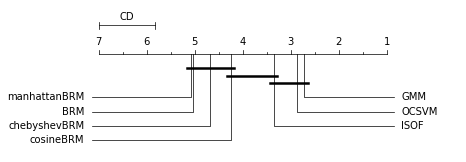

In [ ]:
plot_stats(stat_res)
plt.show()

In [ ]:
latex_table(stat_res)

\begin{table}[h]
\centering
\begin{tabular}{lrrllll}
\toprule
{} &    MR &   MED &   MAD &              CI & $\gamma$ &   Magnitude \\
model        &       &       &       &                 &           &             \\
\midrule
GMM          & 2.725 & 0.500 & 0.134 &  [0.399, 0.589] &     0.000 &  negligible \\
OCSVM        & 2.867 & 0.385 & 0.202 &  [0.270, 0.553] &     0.671 &      medium \\
ISOF         & 3.358 & 0.435 & 0.194 &  [0.284, 0.550] &     0.392 &       small \\
cosineBRM    & 4.250 & 0.302 & 0.170 &  [0.202, 0.449] &     1.294 &       large \\
chebyshevBRM & 4.675 & 0.260 & 0.150 &  [0.175, 0.419] &     1.688 &       large \\
BRM          & 5.042 & 0.267 & 0.148 &  [0.169, 0.392] &     1.644 &       large \\
manhattanBRM & 5.083 & 0.260 & 0.163 &  [0.166, 0.400] &     1.609 &       large \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}
